# Road Following - Live demo

In this notebook, we will use model we trained to move jetBot smoothly on track.

### Load Trained Model

In [8]:
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import glob
import PIL.Image
import os
import numpy as np

In [9]:
# Initialize the model architecture
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(512, 1)

# Load the trained model from the checkpoint file and map it to the CPU
checkpoint = torch.load('checkpoint.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)


# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## set test dataset

In [ ]:
!unzip training_data2.zip
!mv training_data2 test_dataset

Sample 1 - Image Shape: torch.Size([3, 224, 224]), x: 0.9833333492279053
Sample 2 - Image Shape: torch.Size([3, 224, 224]), x: -3.066666603088379
Sample 3 - Image Shape: torch.Size([3, 224, 224]), x: 1.4833333492279053
Sample 4 - Image Shape: torch.Size([3, 224, 224]), x: 0.5
Sample 5 - Image Shape: torch.Size([3, 224, 224]), x: 2.066666603088379


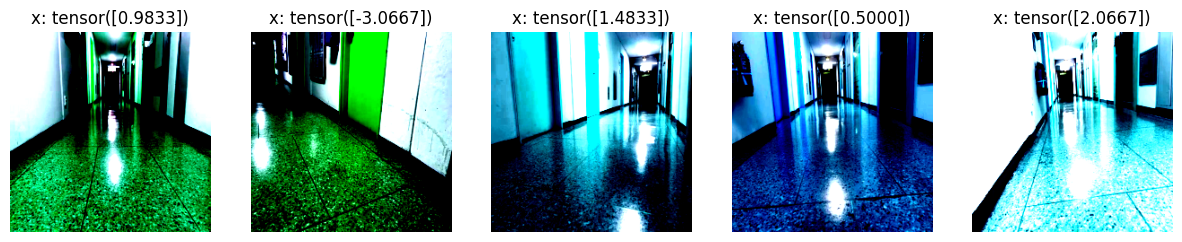

In [11]:
import matplotlib.pyplot as plt

def get_x(file_name):
    """Gets the x value from the image filename"""
    token = file_name.split("-")
    #print(token[0], token[1])
    return (float(int(token[1].split(".")[0]) - 300.0) * 5 / 300.0)

class testDataset(torch.utils.data.Dataset):

    def __init__(self, directory):
        self.directory = directory
        self.image_paths = glob.glob(os.path.join(self.directory, '*.jpg'))
        self.color_jitter = transforms.ColorJitter(0.3, 0.3, 0.3, 0.3)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]

        image = PIL.Image.open(image_path)
        x = float(get_x(os.path.basename(image_path)))

        # if float(np.random.rand(1)) > 0.5:
        #     image = transforms.functional.hflip(image)
        #     x = -x

        image = self.color_jitter(image)
        image = transforms.functional.resize(image, (224, 224))
        image = transforms.functional.to_tensor(image)
        image = image.numpy()[::-1].copy()
        image = torch.from_numpy(image)
        image = transforms.functional.normalize(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        return image, torch.tensor([x]).float()

test_dataset = testDataset('test_dataset')

for i in range(5):
    image, x = test_dataset[i]
    print(f"Sample {i+1} - Image Shape: {image.shape}, x: {x.item()}")

# Visualize selected images with their predicted x values
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    image, x = test_dataset[i]
    image = image.permute(1, 2, 0).numpy()

    axes[i].imshow(image)
    axes[i].set_title(f'x: {x}')
    axes[i].axis('off')

plt.show()


In [12]:
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2
)

## evaluate

Batch [1/13] - Test Loss: 2.5843
Batch [2/13] - Test Loss: 3.0786
Batch [3/13] - Test Loss: 4.3769
Batch [4/13] - Test Loss: 4.5125
Batch [5/13] - Test Loss: 4.8009
Batch [6/13] - Test Loss: 3.6952
Batch [7/13] - Test Loss: 4.1683
Batch [8/13] - Test Loss: 5.6739
Batch [9/13] - Test Loss: 4.2760
Batch [10/13] - Test Loss: 3.7484
Batch [11/13] - Test Loss: 7.2152
Batch [12/13] - Test Loss: 5.0670
Batch [13/13] - Test Loss: 8.1423
Test Loss: 4.7184


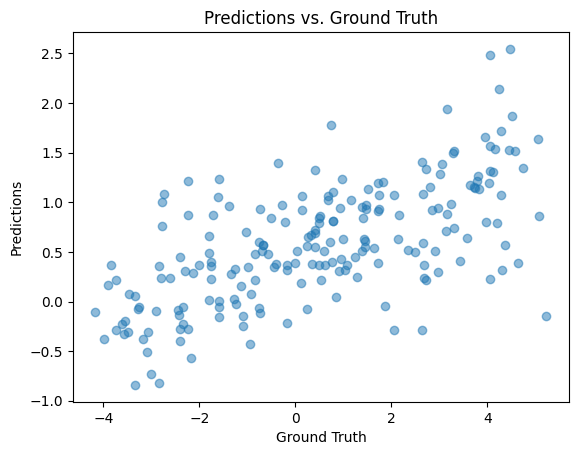

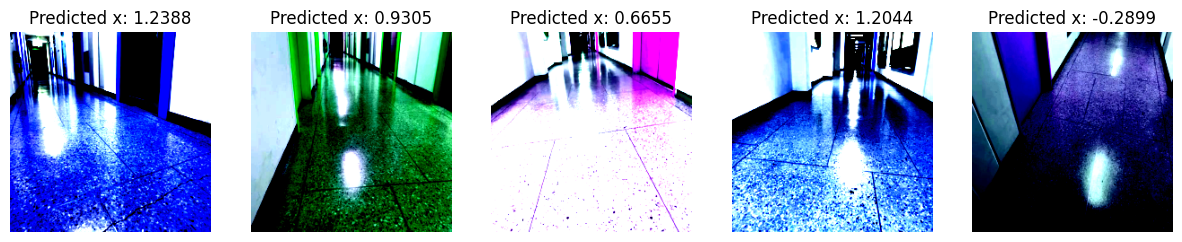

In [13]:
import matplotlib.pyplot as plt

# Ensure matplotlib is installed: pip install matplotlib

# Set the model to evaluation mode
model.eval()

# Initialize counters for debugging
total_test_batches = len(test_loader)
test_batch_count = 0
test_loss = 0.0

# Lists to store predictions and ground truth
all_predictions = []
all_labels = []

# Lists to store images and predicted x values for visualization
selected_images = []
predicted_x_values = []

# Evaluate the model on the test data
with torch.no_grad():
    for images, labels in iter(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = F.mse_loss(outputs, labels)
        test_loss += float(loss)

        # Store predictions and ground truth
        all_predictions.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Store a subset of images and their predicted x values for visualization
        if len(selected_images) < 5:
            selected_images.extend(images.cpu())
            predicted_x_values.extend(outputs.cpu().numpy()[:, 0])

        # Print detailed testing information for each batch
        test_batch_count += 1
        print(f"Batch [{test_batch_count}/{total_test_batches}] - Test Loss: {loss:.4f}")

test_loss /= len(test_loader)

print(f'Test Loss: {test_loss:.4f}')

# Visualize predictions vs. ground truth
plt.scatter(all_labels, all_predictions, alpha=0.5)
plt.title('Predictions vs. Ground Truth')
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.show()

# Visualize selected images with their predicted x values
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    image = selected_images[i].permute(1, 2, 0).numpy()
    predicted_x = predicted_x_values[i]

    axes[i].imshow(image)
    axes[i].set_title(f'Predicted x: {predicted_x:.4f}')
    axes[i].axis('off')

plt.show()


### Connecting Camera

In [17]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import os

def take_photo(save, cnt):

  quality = 0.8
  stop = False

  js = Javascript('''
  async function takePhoto(quality) {
    const div = document.createElement('div');
    const video = document.createElement('video');
    video.style.display = 'block';

    const devices = await navigator.mediaDevices.enumerateDevices();
    const videoDevices = devices.filter((device) => device.kind === 'videoinput');

    // const stream = await navigator.mediaDevices.getUserMedia({video: true});
    const stream = await navigator.mediaDevices.getUserMedia({ video: { deviceId: { exact: videoDevices[0].deviceId } } });

    document.body.appendChild(div);
    div.appendChild(video);
    video.srcObject = stream;
    await video.play();

    // Resize the output to fit the video element.
    google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

    // Wait for the user to click the video preview to capture the image.
    //await new Promise((resolve) => video.onclick = resolve);

    const canvas = document.createElement('canvas');
    canvas.width = video.videoWidth;
    canvas.height = video.videoHeight;
    canvas.getContext('2d').drawImage(video, 0, 0);
    stream.getVideoTracks()[0].stop();
    div.remove();

    // Save the image to a variable or send it to the server if needed.
    const capturedImage = canvas.toDataURL('image/jpeg', quality);
    // You can do further processing or handling of the capturedImage and cursorX here.
    return capturedImage;
  }
  ''')

  display(js)

  captures_image = eval_js('takePhoto({})'.format(quality))

  # Save the image in binary format
  captured_image_data = b64decode(captures_image.split(',')[1])
  filename = os.path.join("live", str(cnt) + ".jpg")

  with open(filename, 'wb') as f:
    f.write(captured_image_data)


  return captured_image_data


In [18]:
# Initialize the model architecture
model_r = models.resnet18(pretrained=False)
model_r.fc = nn.Linear(512, 1)

# Load the trained model from the checkpoint file and map it to the CPU
checkpoint = torch.load('checkpoint.pth', map_location=torch.device('cpu'))
model_r.load_state_dict(checkpoint)


# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_r = model_r.to(device)

In [22]:
import time
from PIL import Image
import io

cnt = 1
try:
    while True:
        time.sleep(1)  # Sleep for 1 second
        b_image = take_photo(save=True, cnt=cnt)

        # image_path = glob.glob(os.path.join("live", '1.jpg'))
        color_jitter = transforms.ColorJitter(0.3, 0.3, 0.3, 0.3)

        time.sleep(1)  # Sleep for 1 second

        #image = PIL.Image.open(image_path)
        image = Image.open(io.BytesIO(b_image))

        image = color_jitter(image)
        image = transforms.functional.resize(image, (224, 224))
        image = transforms.functional.to_tensor(image)
        image = image.numpy()[::-1].copy()
        image = torch.from_numpy(image)
        image = transforms.functional.normalize(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        image = image.unsqueeze(0).to(device)

        # print(image)
        # Set the model to evaluation mode
        model_r.eval()

        # Evaluate the model on the test data
        with torch.no_grad():
            output = model_r(image)
            print(output.cpu().numpy()[:, 0])

        # print(capture_image)

        cnt = cnt + 1

except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))

<IPython.core.display.Javascript object>

[-0.6099566]


<IPython.core.display.Javascript object>

[0.06086343]


<IPython.core.display.Javascript object>

[-0.23533551]


<IPython.core.display.Javascript object>

[-0.18899743]


<IPython.core.display.Javascript object>

[3.5178304]


<IPython.core.display.Javascript object>

[3.7068553]


<IPython.core.display.Javascript object>

[3.18296]


<IPython.core.display.Javascript object>

[-0.6238772]


<IPython.core.display.Javascript object>

[-2.484931]


<IPython.core.display.Javascript object>

[-3.6415186]


<IPython.core.display.Javascript object>

[-3.1222901]


<IPython.core.display.Javascript object>

[-3.0416622]


<IPython.core.display.Javascript object>

[0.38134235]


<IPython.core.display.Javascript object>

[1.6759385]


<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

In [ ]:
# Example usage to capture and save the image as a global variable
take_photo(save=True)
# Access the captured image data from the global variable
print(captured_image_data)

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

### Camera Setting